#### Bayesian inference and Data assimilation SS2023

# Exercise 10 sample sample solution

#### Jin W. Kim (jin.won.kim@uni-potsdam.de)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

#### 1.1
Recall the Bayes rule:

$$
\pi_{X|Y}(x|y) \propto \pi_{Y|X}(y|x)\pi_X(x)
$$

The likelihood $\pi_{Y|X}(y|x)$ is simply the probability density of the noise, shifted by $h(x)$. Therefore,

$$
\pi_{Y|X}(y|x)\propto \exp\big(-\frac{1}{2}(y-h(x))^2\big),\quad \pi_X(x) \propto \exp\big(-\frac{1}{2\cdot2}x^2\big)
$$

Therefore,

$$
\pi_{X|Y}(x|y) = \frac{1}{Z} \exp\big(-\frac{1}{2}(y-x^4-x^2)^2-\frac{1}{4}x^2\big)
$$

#### 1.2
Let

$$
V(x;y) = \frac{1}{2}(x^4+x^2-y)^2 + \frac{1}{4}x^2
$$

Then the posterior density is $$\pi_{X|Y}(x|y) = \frac{1}{Z}\exp\big(-V(x;y)\big)$$ and therefore maximizing the posterior for $y_{obs}=4$ is equivalent to minimize $V(x;4)$. The derivative is given by

$$
\partial_x V(x;4) = (x^4+x^2-4)(4x^3+2x) + \frac{1}{2}x
$$

In [2]:
"Implement the gradient descent algorithm"
def V4(x):
    return 0.5*(x**4 + x**2 - 4)**2 + 0.25*x*x

def DV4(x):
    return (x**4 + x**2 - 4)*(4*x**3 + 2*x) + 0.5*x
    
def grad_descent(DV,x,lam,thr=0.0001,N_max=100000):
    for i in range(N_max):
        if np.abs(DV(x)) < thr:
            print("Converged in {:} steps".format(i))               #check if the threshold is accomplished
            break
        else:
            x = x - lam*DV(x)
    return x

In [3]:
"Run the simulation for few different initial condition"
lam = 0.0005

x_init_1 = -3.
x_final_1 = grad_descent(DV4,x_init_1,lam)
x_init_2 = -1.
x_final_2 = grad_descent(DV4,x_init_2,lam)
x_init_3 = 0.5
x_final_3 = grad_descent(DV4,x_init_3,lam)
x_init_4 = 2.0
x_final_4 = grad_descent(DV4,x_init_4,lam)

print("From x0 ={:4.2f}, the algorithm converged at x={:6.4f}, the value is V_min={:5.3f}".format(x_init_1,x_final_1,V4(x_final_1)))
print("From x0 ={:4.2f}, the algorithm converged at x={:6.4f}, the value is V_min={:5.3f}".format(x_init_2,x_final_2,V4(x_final_2)))
print("From x0 ={:4.2f}, the algorithm converged at x={:6.4f}, the value is V_min={:5.3f}".format(x_init_3,x_final_3,V4(x_final_3)))
print("From x0 ={:4.2f}, the algorithm converged at x={:6.4f}, the value is V_min={:5.3f}".format(x_init_4,x_final_4,V4(x_final_4)))


Converged in 230 steps
Converged in 254 steps
Converged in 370 steps
Converged in 229 steps
From x0 =-3.00, the algorithm converged at x=1.2437, the value is V_min=0.389
From x0 =-1.00, the algorithm converged at x=-1.2437, the value is V_min=0.389
From x0 =0.50, the algorithm converged at x=1.2437, the value is V_min=0.389
From x0 =2.00, the algorithm converged at x=1.2437, the value is V_min=0.389


We observe that there are 2 different local minima. Also note that with this choice of learning parameters, a negative initialization converged to a positive local minimum. 

#### 1.3
The second order derivative of $V$ is given by

$$
\partial_{xx} V(x;4) = (4x^3+2x)(4x^3+2x) + (x^4+x^2-4)(12x^2+2) + \frac{1}{2}
$$

Note that this is an even function. We will pick the first result we found: $m = 1.2437$

In [4]:
"Compute the second order derivative"
m = x_final_1
D2V = (4 * m**3 + 2*m) ** 2 + (m**4 + m**2 - 4)*(12*m**2+2) + 0.5

print("The Laplace approximation is N({:6.4f},{:6.4f})".format(m,1/D2V))

The Laplace approximation is N(1.2437,0.0097)


#### 1.4
See the codes for Langevin method

In [5]:
"Initialization"
N = 10000      #number of samples
dt = 0.005
x0 = 1.0
T = 500

N_t = int(T/dt)

In [6]:
"Run the simulation"
X = x0*np.ones(N)
for t in range(N_t):
    X = X - DV4(X)*dt + np.sqrt(2*dt)*np.random.normal(size=N) 

In [7]:
"The Laplace approximation"
x = np.arange(-1.5,1.8,0.02)
lap_result = np.exp(-0.5*D2V*(x-m)*(x-m))

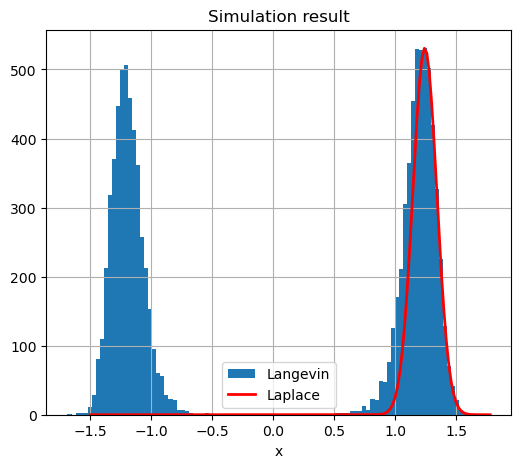

In [8]:
plt.figure(figsize=(6,5))
x_cnt,b,p = plt.hist(X,bins=100, label='Langevin')
plt.plot(x,x_cnt.max()*lap_result, color='red', linewidth=2.0, label='Laplace')    #some re-scaling for the density
plt.title("Simulation result")
plt.xlabel("x")
plt.legend()
plt.grid()

#### 1.5
The Lapalce approximation succesfully approximate a single peak of the desired density. However in this problem, the posterior distribution is bimodal, and it cannot capture the bimodality as it approximates the desired density with a Gaussian distribution.

Meanwhile, Langevin dynamics seems to converge to the true distribution, but it is very slow and expensive in terms of computational power.
The number of evaluations of $\nabla V$ is by far higher for the Langevin dynamics than the gradient descent method to find $m$.

## Problem 2

#### 2.1.
Observe that

$$
\mathbb{E}\big[(X-c)^2\big] = \mathbb{E}[X^2] - 2c\mathbb{E}[X] + c^2 = \big(c-\mathbb{E}[X]\big)^2 + \mathbb{E}[X^2]-\mathbb{E}[X]^2
$$

This is minimized at $c = \mathbb{E}[X]$ and the minimum value is $\mathbb{E}[X^2]-\mathbb{E}[X]^2$.

#### 2.2.
Let $p(x)$ be the probability density function of $X$. We have

$$
\mathbb{E}\big[|X-c|\big] = \int_{-\infty}^{\infty} |x-c|p(x) \,{\rm d}x = \int_{-\infty}^c (c-x)p(x) \,{\rm d}x + \int_c^\infty (x-c)p(x) \,{\rm d}x
$$

Thus the first order optimality condition

$$
\frac{\partial}{\partial c} \Big[\int_{-\infty}^c (c-x)p(x) \,{\rm d}x + \int_c^\infty (x-c)p(x) \,{\rm d}x \Big]
=\int_{-\infty}^c p(x)\,{\rm d}x - \int_c^\infty p(x) \,{\rm d}x 
=0
$$

This is achieved by the median by definition.

## Problem 3

#### 3.1.
By Bayes rule,

$$
\begin{aligned}
\pi_{X|Y}(x_1,x_2|y) &\propto \pi_{Y|X}(y|x_1,x_2)\pi_{X}(x_1,x_2) \\
&\propto \exp\big(-\frac{1}{2\sigma}(y-x_1-x_2)^2\big)\exp\big(-\frac{1}{2}(x_1^2+x_2^2)\big)\\
&=\exp\Big(-\frac{1}{2\sigma}\big((x_1+x_2)^2 -2y(x_1+x_2) +y^2 + \sigma(x_1^2+x_2^2)\big)\Big)
\end{aligned}
$$

Since $x_1^2+x_2^2 = \frac{1}{2}(x_1+x_2)^2 + \frac{1}{2}(x_1-x_2)^2$,

$$
\begin{aligned}
\pi_{X|Y}(x_1,x_2|y) &\propto\exp\Big(-\frac{1}{2\sigma}\big((1+\frac{\sigma}{2})(x_1+x_2)^2 -2y(x_1+x_2)+\frac{\sigma}{2}(x_1-x_2)^2\big)\Big)\\
&\propto \exp\Big(-\frac{1}{2}\cdot\frac{2+\sigma}{2\sigma}\big((x_1+x_2)^2 -2\frac{2y}{2+\sigma}(x_1+x_2)\big)\Big)\exp\Big(-\frac{1}{2\cdot 2}(x_1-x_2)^2\big)\Big)
\end{aligned}
$$

Therefore we conclude $X_1+X_2$ and $X_1-X_2$ are both Gaussian with

$$
\mathbb{P}\big[X_1+X_2 | Y=y\big] = N\Big(\frac{2y}{2+\sigma}, \frac{2\sigma}{2+\sigma}\Big)\\
\mathbb{P}\big[X_1-X_2 | Y=y\big] = N(0, 2)
$$

Therefore we use $X_1 = \frac{1}{2}(X_1+X_2) + \frac{1}{2}(X_1-X_2)$, $X_2 = \frac{1}{2}(X_1+X_2) - \frac{1}{2}(X_1-X_2)$, Therefore,

$$
\mathbb{E}\big[X_1| Y=y\big] = \mathbb{E}\big[X_2| Y=y\big] = \frac{y}{2+\sigma}\\
\text{Var}\big[X_1|Y=y\big] = \text{Var}\big[X_2|Y=y\big] = \frac{1+\sigma}{2+\sigma}
$$

#### 3.2
Regardless of $y$ and $\sigma$, $X_1-X_2$ is unchanged.
* As $\sigma\to\infty$, it is intuitively true that conditioning on $Y$ does not matters, and indeed the distributions of $X_1$ and $X_2$ converge to $N(0,1)$.
* As $\sigma\to 0$, $X_1$ and $X_2$ conditioned on $Y=y$ converges to mean $y/2$ and variance $1/2$. However the variance is due to $X_1-X_2$ direction, and $X_1+X_2$ becomes deterministic constant $y$.